In [1]:
#this script allows you to load your model + the training/validation/test data and view the model's predictions

In [1]:
mode='future prediction' #are we recreating scott's problem (interpolation) or predicting the future (future prediction) 
mode2='validation' #are we predicting on the testing, training, or validation data

In [2]:
if not mode2=='validation':
    !pip3 install keras==2.6
    !pip3 install TensorFlow==2.6.1
    !pip3 install TensorFlow-Addons==0.14.0
    !pip3 install numpy==1.21.6

In [3]:
import numpy as np
n_t = 30 #days per sample
n_train = 1000 #number of training batches
n_val = 1 #total number of validation samples
batch_size=25 #samples per batch
if mode=='future prediction':
    experiment_name = 'convlstm_sla_future_'+ f'{n_t}days_{n_train}samples'
    model_weights_dir = '/home/jovyan/deep-learning-ssh-mapping-JAMES-paper/src/model_weights_future/'+experiment_name+'.h5'
    datadir='/home/jovyan/pre-processed-future-fixed/'
    gs_mean_ssh=np.load("gs_mean_ssh_future.npy")
    gs_std_ssh=np.load("gs_std_ssh_future.npy")
    gs_mean_sst=np.load("gs_mean_sst_future.npy")
    gs_std_sst=np.load("gs_std_sst_future.npy")

elif mode=='interpolation':
    experiment_name='convlstm_sla_sst_' + f'{n_t}days_{n_train}samples'
    model_weights_dir = '/home/jovyan/deep-learning-ssh-mapping-JAMES-paper/src/model_weights/'+experiment_name+'.h5'
    datadir='/home/jovyan/pre-processed/'
    gs_mean_ssh=np.load("gs_mean_ssh_future.npy")
    gs_std_ssh=np.load("gs_std_ssh.npy")
    gs_mean_sst=np.load("gs_mean_sst.npy")
    gs_std_sst=np.load("gs_std_sst.npy")
    

mean_ssh=np.load("gs_mean_ssh.npy")
std_ssh=np.load("gs_std_ssh.npy")
mean_sst=np.load("gs_mean_sst.npy")
std_sst=np.load("gs_std_sst.npy")

stats = (mean_ssh, std_ssh, mean_sst, std_sst)

if mode2=='training':
    #load the model and the weights from training
    from src.generators import *
    from src.models import *
    from src.losses import *
    model=create_ConvLSTM_SLA(n_t)
    model.load_weights(model_weights_dir)
    params = {'dim': (n_t,128,128),
          'batch_size': batch_size,
          'n_channels': 1,
          'shuffle': True,
          'val':'training/',
          'datadir':datadir,
         'stats':stats}
    #load the generator with the training data
    train_ids = []
    for i in range(n_train):
        train_ids.append(f'{i}')
        train_ids.append(f'{i}')
    
    generator = DataGenerator_ssh_interp(train_ids, **params)
    #predict
    prediction=model.predict(generator)
    val='training/'
    np.save("trainingprediction.npy",prediction)
elif mode2=='validation':
    prediction=np.load(experiment_name + 'prediction.npy')
    val='validation/'
elif mode2=='repredict validation':
    #load the model and the weights from training
    from src.generators import *
    from src.models import *
    from src.losses import *
    model=create_ConvLSTM_SLA(n_t)
    model.load_weights(model_weights_dir)
    #load the generator with the validation data
    val_ids = []
    for i in range(n_val):
        val_ids.append(f'{i}')
    batch_size = 25
    params_val = {'dim': (n_t,128,128),
          'batch_size': batch_size,
          'n_channels': 1,
          'shuffle': False,
              'val':'validation/',
          'datadir':datadir,
             'stats':stats}
    validation_generator = DataGenerator_ssh_interp(val_ids, **params_val)
    #predict
    prediction=model.predict(validation_generator)
    val='validation/'
    np.save("validationprediction.npy",prediction)




Text(0, 0.5, 'Loss')

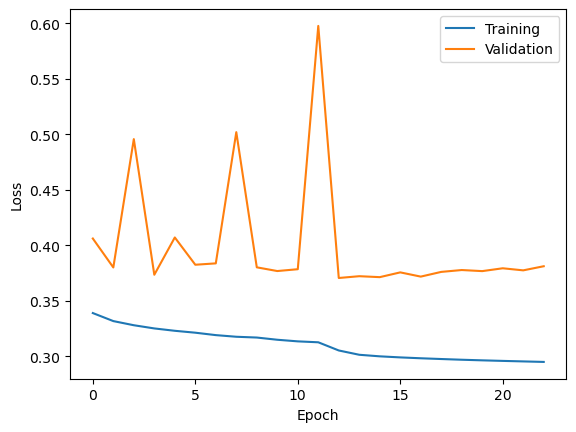

In [4]:
#Load and plot the loss
import matplotlib.pyplot as plt
import matplotlib as mpl
losses=np.load(experiment_name + 'history.npy')
plt.plot(losses[:,0],label='Training')
plt.plot(losses[:,1],label='Validation')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [ ]:
#This compares the results to the binned and plotted output data
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy


batchno=6 #which batch we will inspect
sampleno=0 #which sample we will inspect
tmax=30 #days per sample
n=128 #pixels per region
L_x = 960e3 # size of domain
L_y = 960e3  # size of domain

output_data=np.load(datadir+val+"batch"+str(batchno)+"_outvar.npy") #output data from batch to compare to
outputsample=output_data[sampleno,:,:,:] #specific sample


if mode == 'future prediction':
    savedir='/home/jovyan/future-prediction-images/'+mode2+'/'
elif mode == 'interpolation':
    savedir='/home/jovyan/interp-images/'+mode2+'/'

    
index=0
for batchno in range(1):
    for day in range(tmax):

        #make the axes and the colorbar
        fig, axs = plt.subplot_mosaic([['ax1', 'ax1','ax2','ax2'],
         ['ax1', 'ax1','ax2','ax2'],['colorbar', 'colorbar','colorbar','colorbar'],['BLANK', 'BLANK', 'BLANK','BLANK'],],empty_sentinel="BLANK",figsize=(10,10))
        cmap = mpl.cm.viridis
        norm = mpl.colors.Normalize(vmin=-1, vmax=1)
        fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
            cax=axs['colorbar'], orientation='horizontal', label='SSH')

        #plot the prediction
        axs['ax1'].imshow(prediction[batchno*25+sampleno,day,:,:]*gs_std_ssh+gs_mean_ssh,norm=norm,cmap=cmap)
        input_=np.load(datadir+val+"batch"+str(batchno)+"_invar.npy")

        #bin and plot the output data
        outputgrid, _,_,_ = scipy.stats.binned_statistic_2d(outputsample[day,:,0].flatten(), outputsample[day,:,1].flatten(), outputsample[day,:,2].flatten(), statistic = 'mean', bins=n, range = [[-L_x/2, L_x/2],[-L_y/2, L_y/2]])
        outputgrid = np.rot90(outputgrid)
        outputgrid[np.isnan(outputgrid)] = 0
        axs['ax2'].imshow(outputgrid,norm=norm,cmap=cmap)

        #figure and axis titles
        fig.suptitle("Mode:"+ mode2 + ", Batch number: " + str(batchno) + ", Sample number: " + str(sampleno) + ", Day:" + str(day), fontsize=16)
        axs['ax1'].set_title("Model prediction")
        axs['ax2'].set_title("Binned output data")

        #save the figure to the output data
        plt.savefig(savedir+(str(index).zfill(3))+'.jpg')
        index+=1

In [ ]:
#This calculates u and v and plots them
Omega=7.2921*10**(-5)
theta=35
g=9.8067
f=2*Omega*np.sin(theta)
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy


batchno=6 #which batch we will inspect
sampleno=0 #which sample we will inspect
tmax=30 #days per sample
n=128 #pixels per region
L_x = 960e3 # size of domain
L_y = 960e3  # size of domain

output_data=np.load(datadir+val+"batch"+str(batchno)+"_outvar.npy") #output data from batch to compare to
outputsample=output_data[sampleno,:,:,:] #specific sample


if mode == 'future prediction':
    savedir='/home/jovyan/future-prediction-images/'+mode2+'/'
elif mode == 'interpolation':
    savedir='/home/jovyan/interp-images/'+mode2+'/'

    
index=0
for batchno in range(10):
    for day in range(tmax):

        #make the axes and the colorbar
        fig, axs = plt.subplot_mosaic([['ax1', 'ax1','ax2','ax2'],
         ['ax1', 'ax1','ax2','ax2'],['colorbar', 'colorbar','colorbar','colorbar'],['BLANK', 'BLANK', 'BLANK','BLANK'],],empty_sentinel="BLANK",figsize=(10,10))
        cmap = mpl.cm.viridis
        norm = mpl.colors.Normalize(vmin=-1, vmax=1)
        fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
            cax=axs['colorbar'], orientation='horizontal', label='SSH')

        #calculate u and v
        pred=prediction[batchno*25+sampleno,day,:,:]*gs_std_ssh+gs_mean_ssh
        u=-g/f*np.gradient(pred,axis=0)*(128/L_y) #-g/f * partial SSH/partial y
        v=g/f*np.gradient(pred,axis=1)*(128/L_x) #g/f * partial SSH/partial x
        
        #plot u and v
        axs['ax1'].imshow(u,norm=norm,cmap=cmap)
        axs['ax2'].imshow(v,norm=norm,cmap=cmap)

        #figure and axis titles
        fig.suptitle("Mode:"+ mode2 + ", Batch number: " + str(batchno) + ", Sample number: " + str(sampleno) + ", Day:" + str(day), fontsize=16)
        axs['ax1'].set_title("u")
        axs['ax2'].set_title("v")

        #save the figure to the output data
        plt.savefig(savedir+(str(index).zfill(3))+'.jpg')
        index+=1


In [ ]:
#the ith column is [i,:]
#if there are i columns, then the 